## Loading Keras Libraries

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import mobilenet
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,Softmax
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K

Using TensorFlow backend.
/home/guneet/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/guneet/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/guneet/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/guneet/.local/lib/python3.6/site-packages/tensorflow/python

## Setting Model Parameters

In [2]:
img_width, img_height = 224, 224
epochs = 10
batch_size = 4
n_classes = 2

## Using keras imagedatagenerator to load and transform images in the dataset.

- We don't need to load entire image dataset in the memory

In [3]:
train_data_dir = './PROJECT_CAR_MODEL/Dataset/train/'
test_data_dir = './PROJECT_CAR_MODEL/Dataset/test/'

train_datagen = ImageDataGenerator(rescale = 1./255, #shear_range=0.2, zoom_range=0.2, 
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size = (img_width,img_height), batch_size=4, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size=(img_width, img_height),batch_size=2,class_mode='categorical')

Found 392 images belonging to 2 classes.
Found 101 images belonging to 2 classes.


## Keras MOBILENET
- pretrained Imagenet model will be the starting weights of our model and then we will add final layers for the model. These layers will use relu activation function and the output layer will use softmax

In [4]:
def build_model():
    
    base_model = mobilenet.MobileNet(input_shape=(img_width, img_height, 3),include_top=False,pooling='avg')
    
    for layer in base_model.layers:
        layer.trainable = False
        
    x = base_model.output
    #x = Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    
    #x = Activation('relu')(x)
    #x = Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    
    #x = Activation('relu')(x)
    #predictions = Dense(n_classes, activation='softmax')(x)
    
    x = Dropout(rate=0.4)(x)
    x = Dense(2)(x)
    predictions = Softmax()(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

## Create model and compile

- set the loss and optimization function and the evaluation metrics

In [5]:
model = build_model()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc','mse'])


## Callback method will be EarlyStopping

- model cannot improve loss for validation dataset and reduce learning rate of this  loss cannot be improved

In [6]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop, reduce_lr]

## Training the model

In [7]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [8]:
from keras_tqdm import TQDMNotebookCallback

batch_size = 8

model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)],
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/10


49/49 [==============================] - 8s 168ms/step - loss: 0.9285 - acc: 0.5459 - mse: 0.3068 - val_loss: 0.4094 - val_acc: 0.5000 - val_mse: 0.2566

Epoch 2/10


49/49 [==============================] - 6s 117ms/step - loss: 0.7475 - acc: 0.6276 - mse: 0.2502 - val_loss: 0.7440 - val_acc: 0.7500 - val_mse: 0.1440

Epoch 3/10


49/49 [==============================] - 6s 120ms/step - loss: 0.5818 - acc: 0.7347 - mse: 0.1865 - val_loss: 0.8139 - val_acc: 0.7083 - val_mse: 0.1917

Epoch 4/10


49/49 [==============================] - 6s 127ms/step - loss: 0.5747 - acc: 0.7347 - mse: 0.1779 - val_loss: 0.4014 - val_acc: 0.8333 - val_mse: 0.0919

Epoch 5/10


49/49 [==============================] - 7s 144ms/step - loss: 0.7139 - acc: 0.7398 - mse: 0.2029 - val_loss: 0.2321 - val_acc: 0.6957 - val_mse: 0.1751

Epoch 6/10


49/49 [==============================] - 7s 143ms/step - loss: 0.6589 - acc: 0.7194 - mse: 0.2084 - val_loss: 0.8774 - val_acc: 0.7083 - val_mse: 0.1774

Epoch 7/10


49/49 [==============================] - 7s 153ms/step - loss: 0.5193 - acc: 0.7398 - mse: 0.1739 - val_loss: 1.5821 - val_acc: 0.7500 - val_mse: 0.1885

Epoch 8/10


49/49 [==============================] - 7s 134ms/step - loss: 0.5479 - acc: 0.7551 - mse: 0.1697 - val_loss: 0.0729 - val_acc: 0.9167 - val_mse: 0.0496

Epoch 9/10


49/49 [==============================] - 7s 134ms/step - loss: 0.6447 - acc: 0.7551 - mse: 0.1917 - val_loss: 0.1090 - val_acc: 0.7826 - val_mse: 0.1352

Epoch 10/10


49/49 [==============================] - 7s 137ms/step - loss: 0.3355 - acc: 0.8469 - mse: 0.1089 - val_loss: 0.0096 - val_acc: 0.7917 - val_mse: 0.1586




## Plotting Accuracy, Loss and MSE

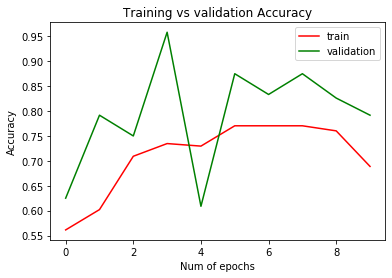

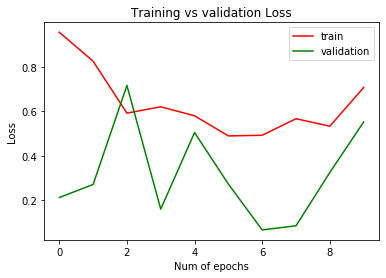

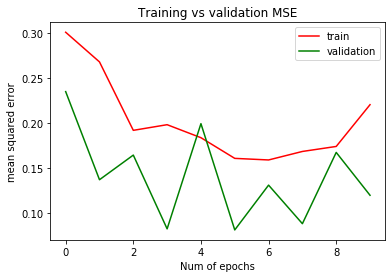

In [15]:
from matplotlib import pyplot as plt
plt.figure(0)
plt.plot(model_history.history['acc'],'r')
plt.plot(model_history.history['val_acc'],'g')
plt.xlabel("Num of epochs")
plt.ylabel("Accuracy")
plt.title("Training vs validation Accuracy")
plt.legend(['train', 'validation'])

plt.figure(1)
plt.plot(model_history.history['loss'],'r')
plt.plot(model_history.history['val_loss'],'g')
plt.xlabel("Num of epochs")
plt.ylabel("Loss")
plt.title("Training vs validation Loss")
plt.legend(['train', 'validation'])

plt.figure(2)
plt.plot(model_history.history['mse'],'r')
plt.plot(model_history.history['val_mse'],'g')
plt.xlabel("Num of epochs")
plt.ylabel("mean squared error")
plt.title("Training vs validation MSE")
plt.legend(['train', 'validation'])

plt.show()

## Evaluate trained model

In [9]:
loss, acc, mse = model.evaluate_generator(test_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False)

print("Accuracy is:",acc)

Accuracy is: 0.7821782231330872


In [10]:
import numpy as np
pred = model.predict_generator(test_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)
predicted = np.argmax(pred, axis=1)

51/51 [==============================] - 3s 63ms/step


## Confusion Matrix

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report

print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, np.argmax(pred, axis=1))
#plt.figure(figsize = (30,20))
#sns.set(font_scale=1.4) #for label size
#sns.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
#plt.show(cm)
print(cm)
print('Classification Report')

class_names = ['maruti suzuki swift', 'bmw z4']
print(classification_report(test_generator.classes, predicted, target_names=class_names))

Confusion Matrix
[[17 38]
 [20 26]]
Classification Report
                     precision    recall  f1-score   support

maruti suzuki swift       0.46      0.31      0.37        55
             bmw z4       0.41      0.57      0.47        46

           accuracy                           0.43       101
          macro avg       0.43      0.44      0.42       101
       weighted avg       0.44      0.43      0.42       101



## Check some images with their prediction

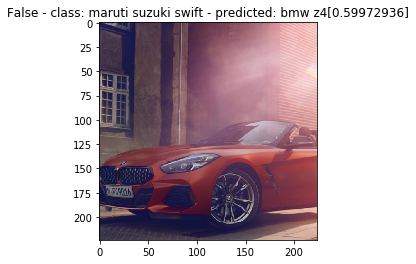

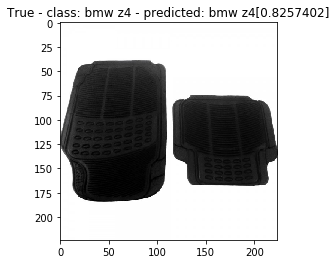

In [16]:
def predict_one(model):
    image_batch, classes_batch = next(test_generator)
    predicted_batch = model.predict(image_batch)
    for k in range(0,image_batch.shape[0]):
      image = image_batch[k]
      pred = predicted_batch[k]
      the_pred = np.argmax(pred)
      predicted = class_names[the_pred]
      val_pred = max(pred)
      the_class = np.argmax(classes_batch[k])
      value = class_names[np.argmax(classes_batch[k])]
      plt.figure(k)
      isTrue = (the_pred == the_class)
      plt.title(str(isTrue) + ' - class: ' + value + ' - ' + 'predicted: ' + predicted + '[' + str(val_pred) + ']')
      plt.imshow(image)

predict_one(model)

## Saving the model

In [17]:
# import pickle

# filename = './PROJECT_CAR_MODEL/Dataset/saved_model.pkl'

# pickle.dump(model, open(filename, 'wb'))

## checking model by loading from pickle

In [18]:
# import tensorflow as tf

# model_from_pickle = pickle.loads(saved_model)


# image_file = './PROJECT_CAR_MODEL/Dataset/train/maruti_suzuki_swift/1.Maruti-Suzuki-New-Swift-Left-Front-Three-Quarter-88877.jpg'
# class_batch =1

# def load_image(img_file, target_size=(224,224)):
#     X = np.zeros((1, *target_size, 3))
#     X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
#         img_file, 
#         target_size=target_size)
#     )
#     X = tf.keras.applications.mobilenet.preprocess_input(X)
#     return X

# image_batch = load_image(image_file)
# predicted_batch = model_from_pickle.predict(image_batch)



In [19]:
#print(predicted_batch[0,0])

In [20]:
# the_pred = np.argmax(predicted_batch)

# the_pred

In [23]:
# predicted = class_names[the_pred]
# predicted
#import matplotlib.image as mpimg

# img = mpimg.imread(image_file)

# class_name = "maruti_suzuki_swift"

# class_list = ["hundai i10","maruti_suzuki_swift"]

# if class_name == "maruti_suzuki_swift":
#     the_class = 1
    
# predicted = class_list[the_pred]
# isTrue = (the_pred == the_class)
# plt.title(str(isTrue) + ' - class: ' + class_name + ' - ' + 'predicted: ' + predicted + '[' + str(predicted_batch[0,the_pred]) + ']')
    
# plt.imshow(img)

In [25]:
#Save the model
# serialize model to JSON
model_json = model.to_json()
with open("/home/guneet/Desktop/DEPLOY/models/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/home/guneet/Desktop/DEPLOY/models/model.h5")
print("Saved model to disk")

Saved model to disk
